In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as smp

## RK4 method

In [2]:
def RK4(f, x0, params=None, t0 = 0.0, h = 0.01, tFin = 10.0):
    y = np.zeros(shape=(len(x0), 1))
    k1 = k2 = k3 = k4 = np.zeros(shape=(len(x0)))
    y[:, 0] = x0
    t = t0
    timeArray = np.array([])
    while t < tFin:
        timeArray = np.append(timeArray, t)
        k1 = f(x0, t, params)
        k2 = f(x0 + h*k1/2, t + h/2, params)
        k3 = f(x0 + h*k2/2, t + h/2, params)
        k4 = f(x0 + h*k3, t + h, params)
        x0 = x0 + h/6 * (k1 + 2*k2 + 2*k3 + k4)
        t = t + h
        y = np.column_stack((y, x0))
    timeArray = np.append(timeArray, t)
    return y, timeArray

## 1. Projectile with drag

### Equations of motion for simple drag and full drag models

In [3]:
def projectileSimple(x0, t, params=None):
    x, y, vx, vy = x0
    dx = vx
    dy = vy
    v = np.sqrt(dx**2 + dy**2)

    rho = 1.22
    cd = 0.47
    drag = 1/2 * rho * cd * np.pi*(0.08)**2

    dvx = 0 - drag * v * dx
    dvy = -9.8 - drag * v * dy
    return np.array([dx, dy, dvx, dvy])


def projectileFull(x0, t, params=None):
    x, y, vx, vy = x0
    dx = vx
    dy = vy
    v = np.sqrt(dx**2 + dy**2)

    rho = 1.22 * (1 - 6.5e-3 * y/288.15)**(2.5)
    cd = 0.47 * (1 + 1.5/(1 + np.exp((v - 35.0)/5.0)))
    drag = 1/2 * rho * cd * np.pi*(0.08)**2

    dvx = 0 - drag * v * dx
    dvy = -9.8 - drag * v * dy
    return np.array([dx, dy, dvx, dvy])

v = 100
vx0 = v * np.cos(np.pi/6)
vy0 = v * np.sin(np.pi/6)
y1, t1 = RK4(projectileSimple, [0.0, 0.0, vx0, vy0])
y2, t2 = RK4(projectileFull, [0.0, 0.0, vx0, vy0])

### Plotting of projectile trajectories

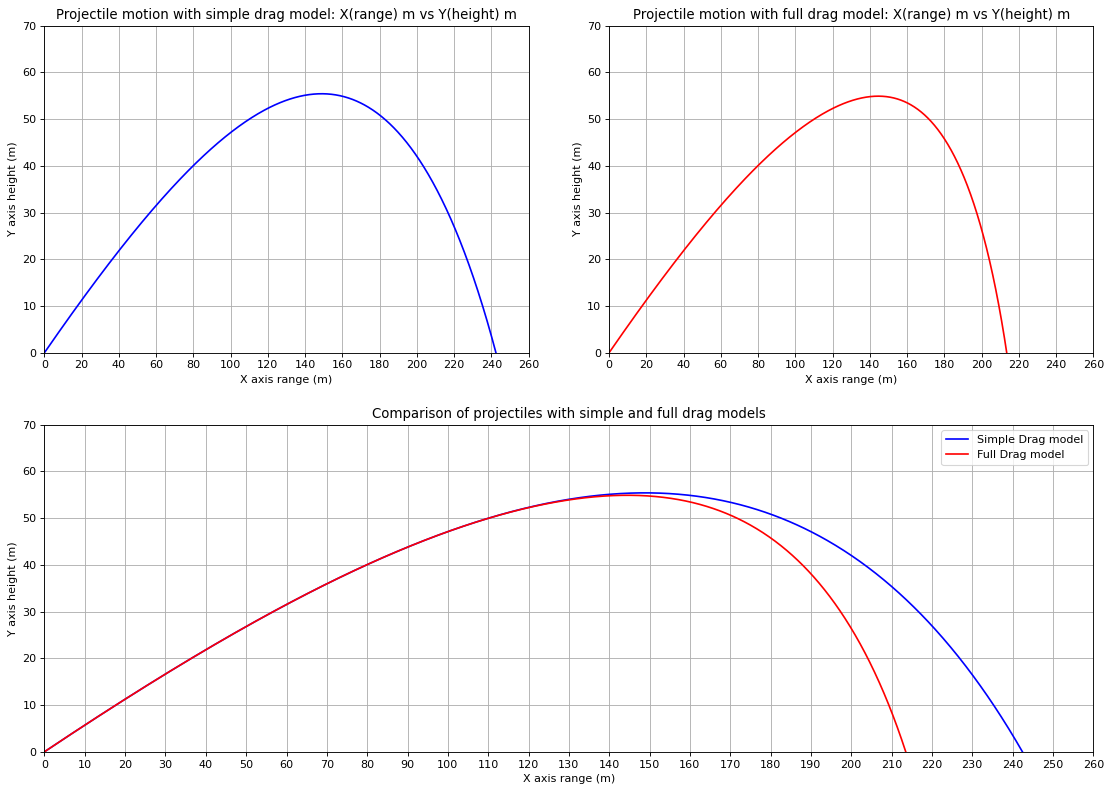

In [4]:
fig = plt.figure(1, figsize=(14, 10), dpi=80)
ax1 = plt.subplot(221)

ax1.plot(y1[0], y1[1], color="blue")
ax1.set_ylim(0, 70)
ax1.set_title("Projectile motion with simple drag model: X(range) m vs Y(height) m")
ax1.set_xlabel("X axis range (m)")
ax1.set_ylabel("Y axis height (m)")
ax1.grid()
ax1.set_xticks(np.arange(0, 300, 20))
ax1.set_xlim(0, 260)

ax2 = plt.subplot(222)
ax2.plot(y2[0], y2[1], color="red")
ax2.set_ylim(0, 70)
ax2.set_title("Projectile motion with full drag model: X(range) m vs Y(height) m")
ax2.set_xlabel("X axis range (m)")
ax2.set_ylabel("Y axis height (m)")
ax2.grid()
ax2.set_xticks(np.arange(0, 300, 20))
ax2.set_xlim(0, 260)

ax3 = plt.subplot(212)
ax3.plot(y1[0], y1[1], color='blue', label='Simple Drag model')
ax3.plot(y2[0], y2[1], color='red', label='Full Drag model')
ax3.legend()
ax3.grid()
ax3.set_xlabel("X axis range (m)")
ax3.set_ylabel("Y axis height (m)")
ax3.set_xticks(np.arange(0, 300, 10))
ax3.set_ylim(0, 70)
ax3.set_xlim(0, 260)
ax3.set_title("Comparison of projectiles with simple and full drag models")

plt.tight_layout(w_pad=3, h_pad=2)

plt.show()
plt.close()


## 2. Double Pendulum

### Equations of motion

In [5]:
theta1, theta2, omega1, omega2 = smp.symbols("theta1, theta2, omega1, omega2", cls=smp.Function)
m1, m2, l1, l2, g, t = smp.symbols("m1 m2 l1 l2 g t")

theta1 = theta1(t)
theta2 = theta2(t)
omega1 = smp.diff(theta1, t)
omega2 = smp.diff(theta2, t)
alpha1 = smp.diff(omega1, t)
alpha2 = smp.diff(omega2, t)

T = 1/2 * (m1 * (l1**2 * omega1**2) + m2 * (l1**2 * omega2**2 + l2**2 * omega2**2 + 2 * omega1 * omega2 * l1 * l2 * smp.cos(theta1 - theta2)))
V = -g * (m1 * l1 * smp.cos(theta1) + m2 * (l1 * smp.cos(theta1) + l2 * smp.cos(theta2)))

L = T - V
LE1 = smp.diff(smp.diff(L, omega1), t) - smp.diff(L, theta1).simplify()
LE2 = smp.diff(smp.diff(L, omega2), t) - smp.diff(L, theta2).simplify()

sols = smp.solve([LE1, LE2], [alpha1, alpha2])

omega1d = sols[alpha1]
omega2d = sols[alpha2]

dtheta1_dt = smp.lambdify(omega1, omega1)
dtheta2_dt = smp.lambdify(omega2, omega2)

domega1_dt = smp.lambdify((t, g, m1, m2, l1, l2, theta1, theta2, omega1, omega2), omega1d)
domega2_dt = smp.lambdify((t, g, m1, m2, l1, l2, theta1, theta2, omega1, omega2), omega2d)

def doublePendulum(x0, t, params):
    the1, z1, the2, z2 = x0
    g, m1, m2, l1, l2 = params
    return np.array([
        dtheta1_dt(z1),
        domega1_dt(t, g, m1, m2, l1, l2, the1, the2, z1, z2),
        dtheta2_dt(z2),
        domega2_dt(t, g, m1, m2, l1, l2, the1, the2, z1, z2),
    ])


### Small oscillations
#### $L_1 = m_1 = 1$ and $L_2 = m_2 = 0.01$
#### $\dot{\theta_1}(t=0) = 0.1$, $\dot{\theta_2}(t=0) = 0$

In [6]:
def solveAndPlotDoublePendulum(x0, titleText, params=None, h=0.01, plotom2 = False):
    if params is None:
        g = 9.8
        m1 = 1.0
        m2 = 0.01
        l1 = 1.0
        l2 = 0.01
    g, m1, m2, l1, l2 = params
    y, t = RK4(doublePendulum, x0=x0, params=(g, m1, m2, l1, l2), h=h, tFin=30)
    th1, om1, th2, om2 = y[0], y[1], y[2], y[3]

    if plotom2:
        fig = plt.figure(1, figsize=(10,13), dpi=100)
        fig.suptitle(titleText)
        ax = plt.subplot(411)
        ax.plot(t, th1, label=r"$\theta_1$")
        ax.grid()
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Angle from equilibrium (radians)")
        ax.set_title(r"$\theta_1$ vs time")
        ax.legend()

        ax = plt.subplot(412)
        ax.plot(t, om1, label=r"$\omega_1$")
        ax.grid()
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Angular velocity (rad/s)")
        ax.set_title(r"$\omega_1 = \frac{d\theta_1}{dt}$ vs time")
        ax.legend()

        ax = plt.subplot(413)
        ax.plot(t, th2, label=r"$\theta_2$")
        ax.grid()
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Angle from equilibrium (radians)")
        ax.set_title(r"$\theta_2$ vs time")
        ax.legend()

        ax = plt.subplot(414)
        ax.plot(t, om2, label=r"$\omega_2$")
        ax.grid()
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Angular velocity (rad/s)")
        ax.set_title(r"$\omega_2 = \frac{d\theta_2}{dt}$ vs time")
        ax.legend()
        plt.tight_layout()
        plt.show()
        plt.close()

    else:
        fig = plt.figure(1, figsize=(10,8), dpi=100)
        fig.suptitle(titleText)
        ax = plt.subplot(211)
        ax.plot(t, th1, label=r"$\theta_1$")
        ax.grid()
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Angle from equilibrium (radians)")
        ax.set_title(r"$\theta_1$ vs time")
        ax.legend()

        ax = plt.subplot(212)
        ax.plot(t, om1, label=r"$\omega_1$")
        ax.grid()
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Angular velocity (rad/s)")
        ax.set_title(r"$\omega_1 = \frac{d\theta_1}{dt}$ vs time")
        ax.legend()
        plt.tight_layout()
        plt.show()
        plt.close()

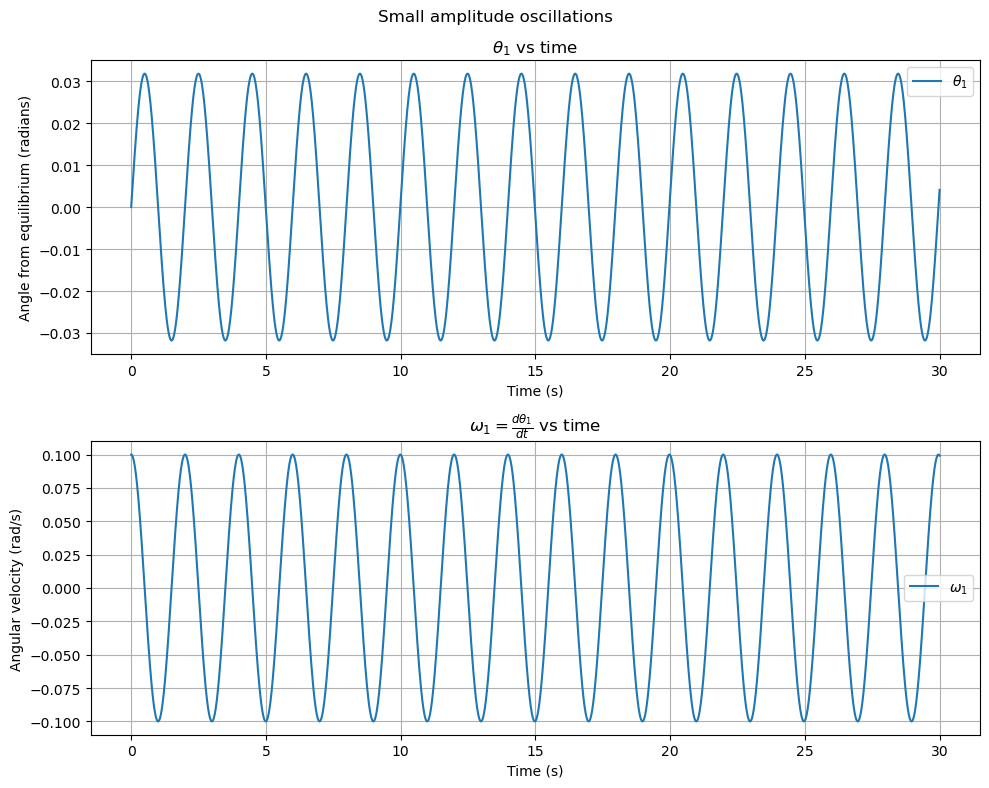

In [7]:
solveAndPlotDoublePendulum(x0=np.array([0.0, 0.1, 0.0, 0.0]),titleText=r"Small amplitude oscillations", params=(9.8, 1.0, 0.01, 1.0, 0.01))

### Larger amplitudes for $L_1 = L_2 = m_1 = m_2 = 1$
#### 1. $\dot{\theta_1}(t=0) = 0.1$, $\dot{\theta_2}(t=0) = 0$

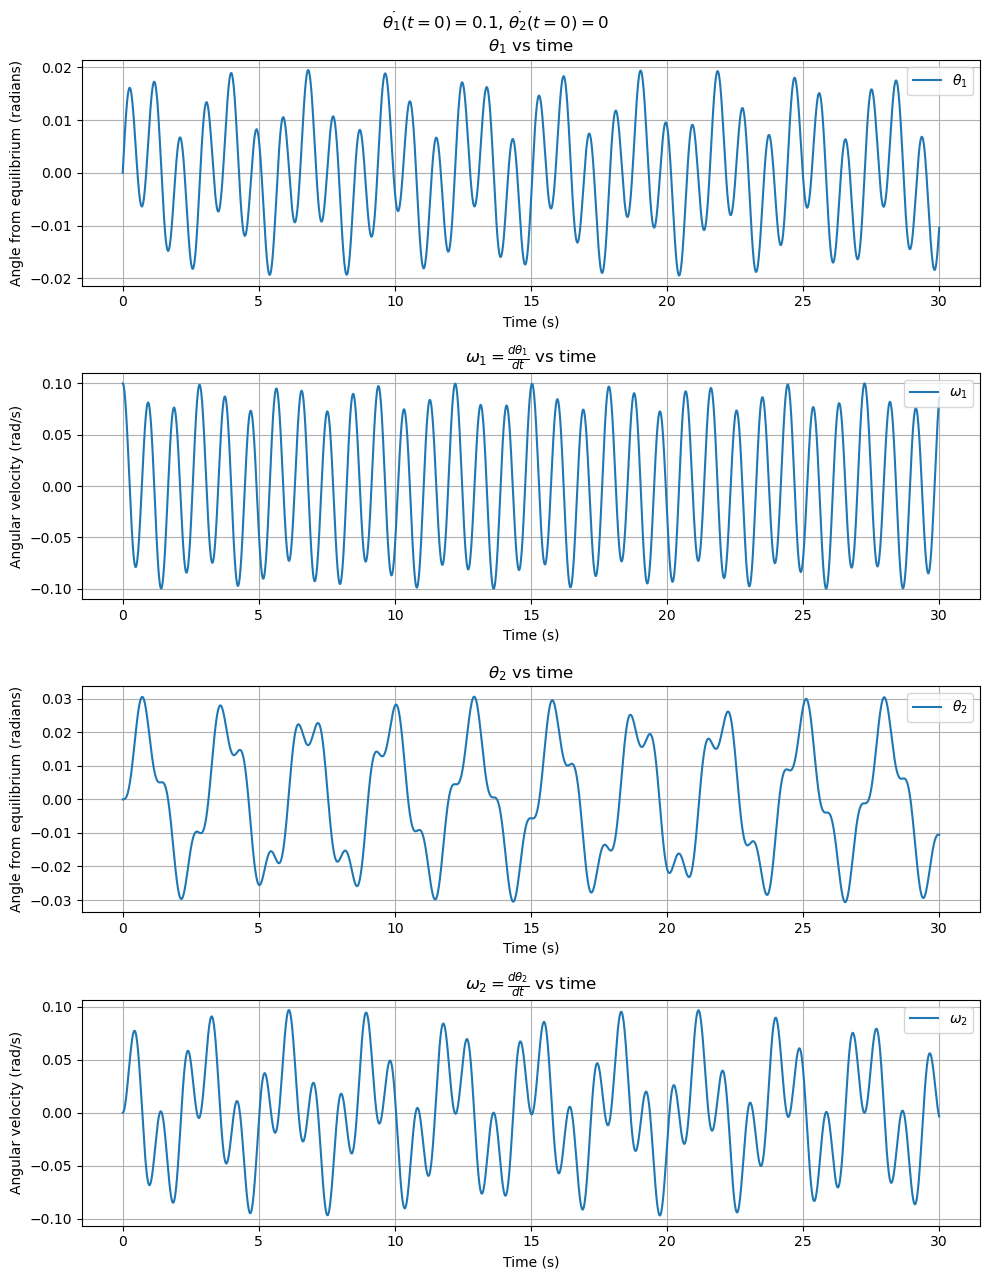

In [8]:
solveAndPlotDoublePendulum(x0=np.array([0.0, 0.1, 0.0, 0.0]),titleText=r"$\dot{\theta_1}(t=0) = 0.1$, $\dot{\theta_2}(t=0) = 0$", plotom2=True, params=(9.8, 1.0, 1.0, 1.0, 1.0))

#### 2. $\dot{\theta_1}(t=0) = 0.1$, $\dot{\theta_2}(t=0) = 0.2$

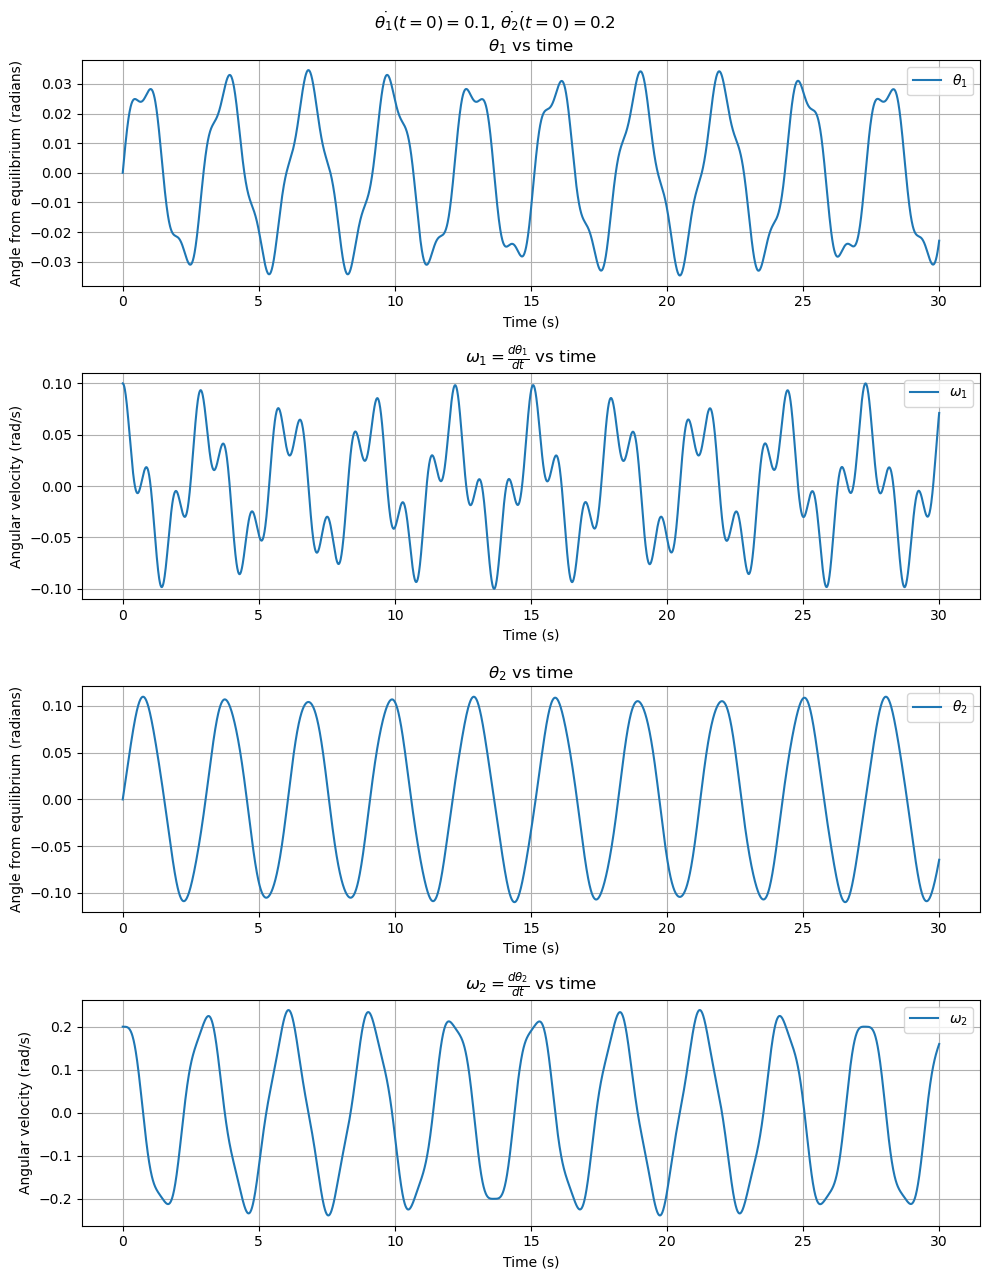

In [9]:
solveAndPlotDoublePendulum(x0=np.array([0.0, 0.1, 0.0, 0.2]),titleText=r"$\dot{\theta_1}(t=0) = 0.1$, $\dot{\theta_2}(t=0) = 0.2$", plotom2=True, params=(9.8, 1.0, 1.0, 1.0, 1.0))

#### 3. $\dot{\theta_1}(t=0) = 1$, $\dot{\theta_2}(t=0) = 0$

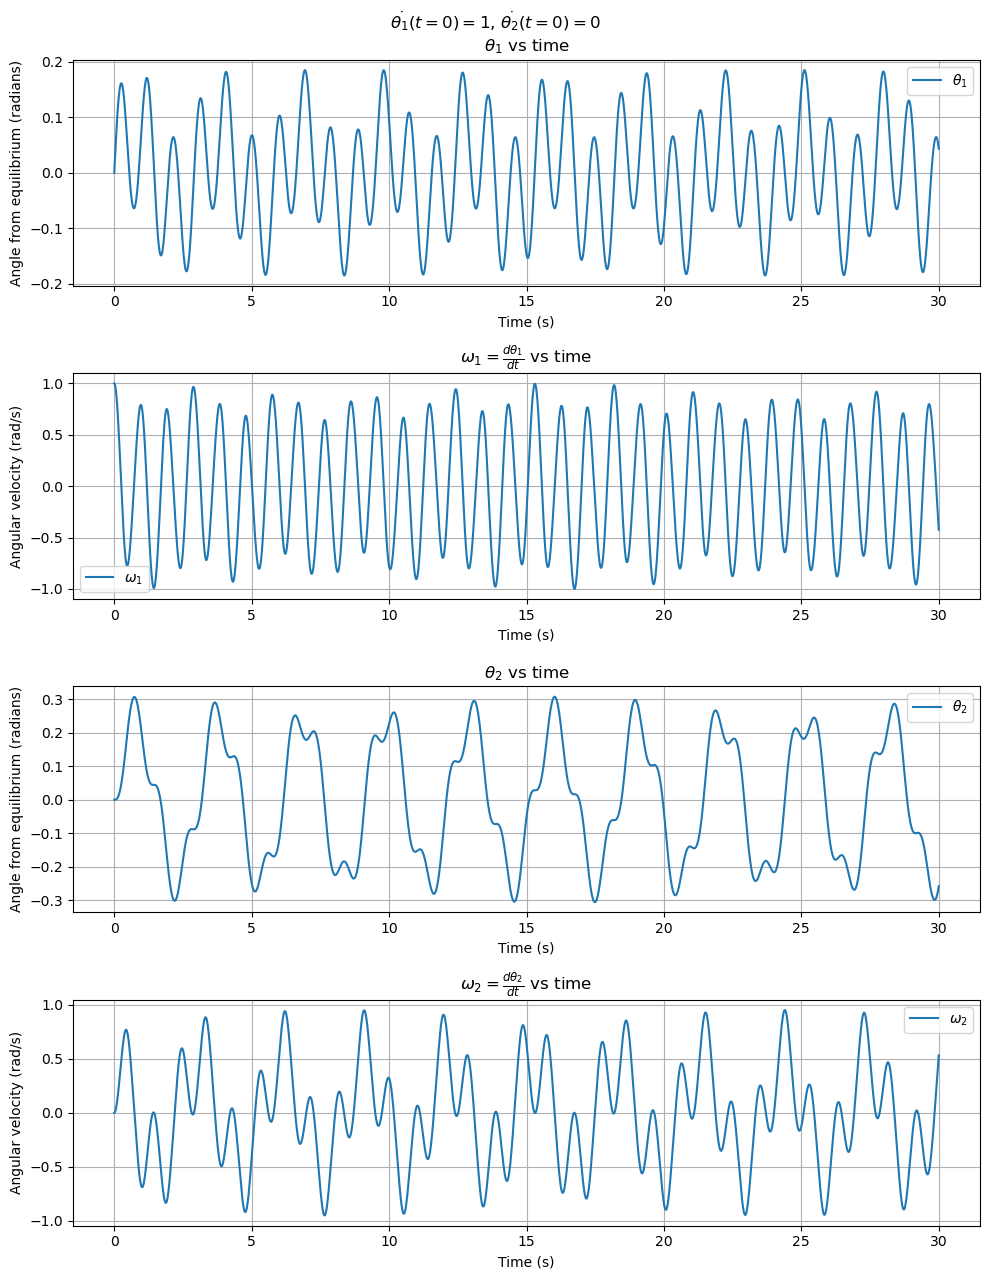

In [10]:
solveAndPlotDoublePendulum(x0=np.array([0.0, 1.0, 0.0, 0.0]),titleText=r"$\dot{\theta_1}(t=0) = 1$, $\dot{\theta_2}(t=0) = 0$", plotom2=True, params=(9.8, 1.0, 1.0, 1.0, 1.0))

#### 4. $\dot{\theta_1}(t=0) = 3$, $\dot{\theta_2}(t=0) = 1$

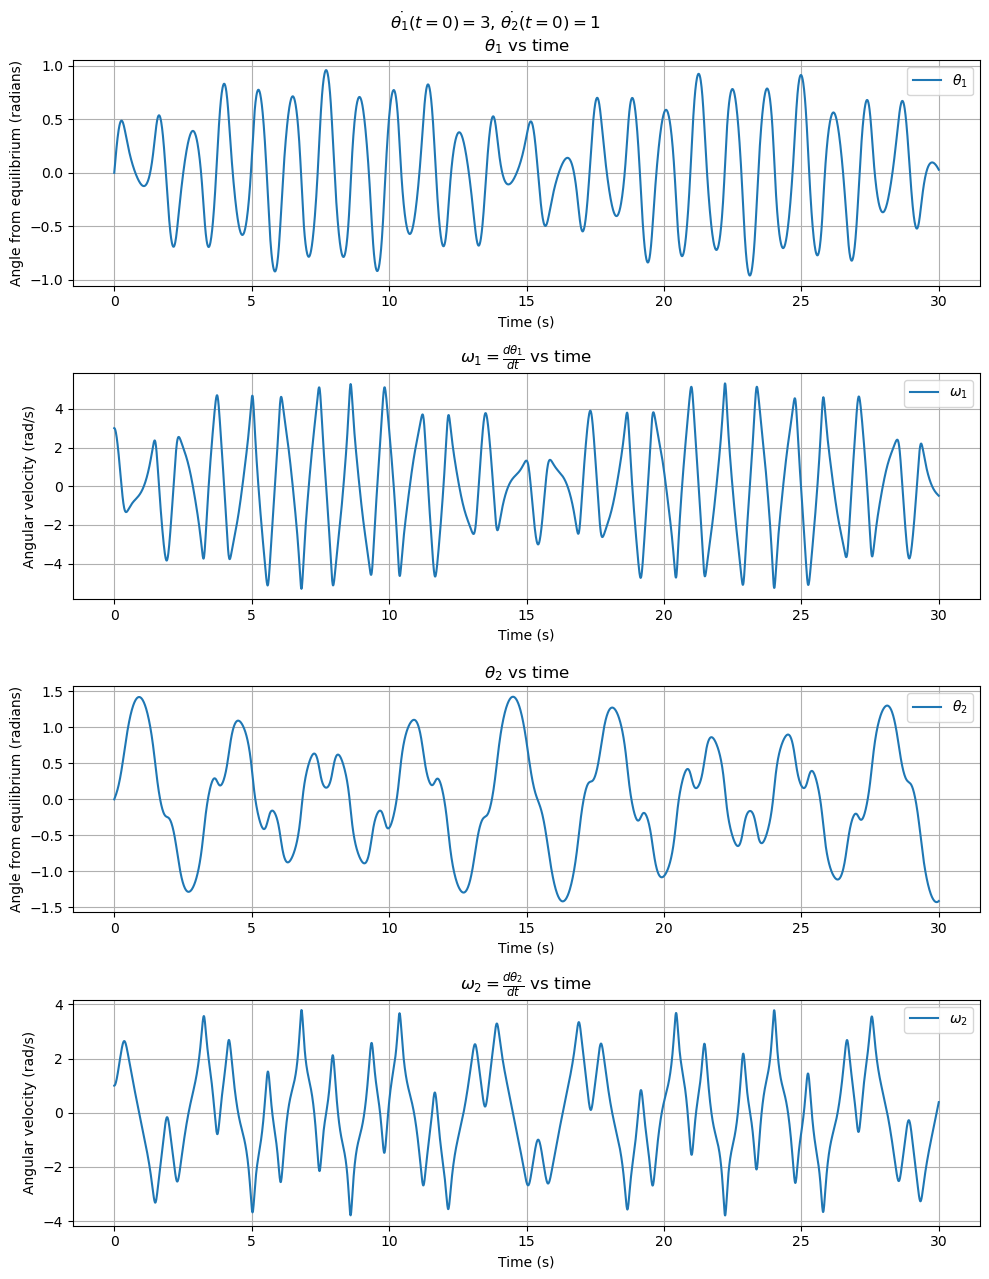

In [11]:
solveAndPlotDoublePendulum(x0=np.array([0.0, 3.0, 0.0, 1.0]),titleText=r"$\dot{\theta_1}(t=0) = 3$, $\dot{\theta_2}(t=0) = 1$", plotom2=True, params=(9.8, 1.0, 1.0, 1.0, 1.0))

#### Energy check

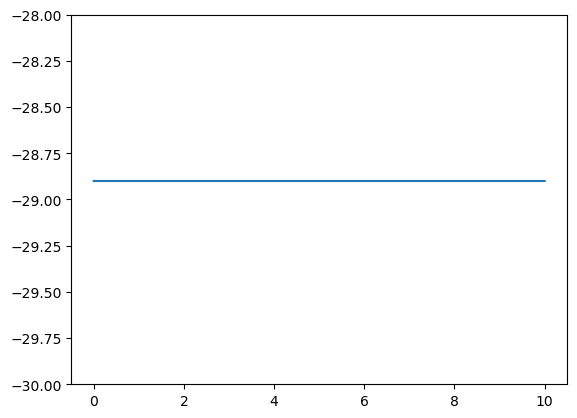

In [114]:
E = T + V
m1, m2, l1, l2, g, t = smp.symbols("m1 m2 l1 l2 g t")
E_lambd = smp.lambdify((t, g, m1, m2, l1, l2, theta1, theta2, omega1, omega2), E, "numpy")

g = 9.8
m1 = 1.0
m2 = 1.0
l1 = 1.0
l2 = 1.0
x0 = [0.0,1.0,0.0,0.0]
y, t = RK4(doublePendulum, x0=x0, params=(g, m1, m2, l1, l2), h=0.001, tFin=10)

energyTime = E_lambd(t,g,m1,m2,l1,l2,y[0],y[2],y[1],y[3])
plt.ylim(-30, -28)
plt.plot(t, energyTime)

In [121]:
def Verlet(f, x0, v0, params=None, t0 = 0.0, h = 1e-4, tFin = 10.0):
    y = np.zeros(shape=(len(x0), 1))
    v_y = np.zeros(shape=(len(x0), 1))
    k = np.zeros(shape=(len(x0)))
    t = t0
    y[:, 0] = x0
    idx = 0 
    x1 = x0 + v0*h + 0.5 * f(x0,v0,t,params) * h**2
    y = np.column_stack((y, x1))
    v_y[:, 0] = v0
    
    timeArray = np.array([t])
    t = t+h
    idx = 1
    while t < tFin:
        timeArray = np.append(timeArray, t)
        x0 = y[:, idx-1]
        x1 = y[:, idx]

        k = f(x0,v0, t, params)
        x2 = 2.0*x1 - x0 + k * h**2
        v = (x2 - x0)/(2.0 * h)
        v0 = v
        v_y = np.column_stack((v_y, v))
        t = t + h
        idx = idx + 1
        y = np.column_stack((y, x2))
    v_y = np.column_stack((v_y, (y[:, -1] - y[:, -3])/(2.0*h)))
    timeArray = np.append(timeArray, t)
    return y, v_y, timeArray

In [127]:
def doublePendulumVerlet(x0, v0, t, params):
    the1, the2 = x0
    z1, z2 = v0
    g, m1, m2, l1, l2 = params
    return np.array([
        domega1_dt(t, g, m1, m2, l1, l2, the1, the2, z1, z2),
        domega2_dt(t, g, m1, m2, l1, l2, the1, the2, z1, z2),
    ])

y,vy,t = Verlet(doublePendulumVerlet, np.array([0.0, 0.0]), np.array([1.0, 0.0]), params=(9.8, 1.0, 1.0, 1.0, 1.0))


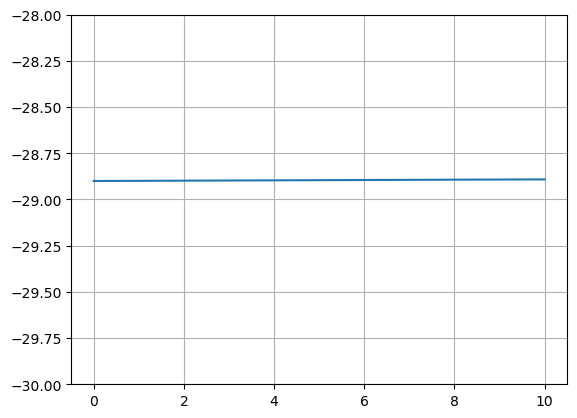

In [128]:
energyTime = E_lambd(t,g,m1,m2,l1,l2,y[0],y[1],vy[0],vy[1])
plt.ylim(-30,-28)
plt.grid()
plt.plot(t, energyTime)

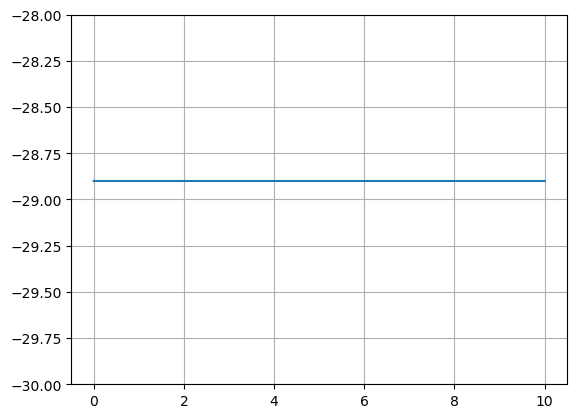

In [129]:
g = 9.8
m1 = 1.0
m2 = 1.0
l1 = 1.0
l2 = 1.0
x0 = [0.0,1.0,0.0,0.0]
y, t = RK4(doublePendulum, x0=x0, params=(g, m1, m2, l1, l2), h=0.001, tFin=10)

energyTime = E_lambd(t,g,m1,m2,l1,l2,y[0],y[2],y[1],y[3])
plt.ylim(-30,-28)
plt.grid()
plt.plot(t, energyTime)